In [1]:
##safety executable check (for conda env)
import sys
sys.executable

'/home/hackerman/anaconda2/envs/anaconda2_py27/bin/python'

### Avalinguo Audioset Experiments

- This data set was constructed by researchers at the Intelligent Systems department at ITESM
- It contains audio segments of conversation among people. The segments are contained within three folders representing the fluency levels; Low, Intermediate, High
- The audio files were gathered from the internet, from known friends and from audios provided by the language center at ITESM

### Audio Feature Extraction

In [318]:
# coding= UTF-8
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import soundfile as sf

##Return audio features 
def feature_extraction(file_name):
    #X, sample_rate = sf.read(file_name, dtype='float32')
    X , sample_rate = librosa.load(file_name, sr=None) #Can also load file using librosa
    if X.ndim > 1:
        X = X[:,0]
    X = X.T
    
    ## stFourier Transform
    stft = np.abs(librosa.stft(X))
            
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=20).T, axis=0) #Returns N_mel coefs
    rmse = np.mean(librosa.feature.rmse(y=X).T, axis=0) #RMS Energy for each Frame (Stanford's). Returns 1 value 
    spectral_flux = np.mean(librosa.onset.onset_strength(y=X, sr=sample_rate).T, axis=0) #Spectral Flux (Stanford's). Returns 1 Value
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=X).T, axis=0) #Returns 1 value
    
    #mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0) #Returns 128 values
    #chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0) #Returns 12 values
    #contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0) #Returns 7 values
    #tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0) #tonal centroid features Returns 6 values
    
    ##Return computed audio features
    return mfccs, rmse, spectral_flux, zcr
    
# Audio parsing: Function makes call for feature extraction and returns array with features and labels 
def parse_audio_files(parent_dir, sub_dirs, file_ext='*.mp3'): # Audio Format

    n_mfccs = 20 # This variable is tunneable with each run
    number_of_features = 3 + n_mfccs
    #number_of_features = 154 + n_mfccs # 154 are the total values returned by rest of computed features
    features, labels = np.empty((0,number_of_features)), np.empty(0)
    
    ##Extract features for each audio file
    for label, sub_dir in enumerate(sub_dirs): ##The enumerate() function adds a counter to an iterable.
        for file_name in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)): ##parent is data, sub_dirs are the classes
            print "Actual File Name: ", file_name
            try:
                mfccs, rmse, spectral_flux, zcr = feature_extraction(file_name)
                #mfccs, zcr, mel, chroma, contrast, tonnetz = feature_extraction(file_name)
            except Exception as e:
                print("[Error] there was an error in feature extraction. %s" % (e))
                continue
             
            extracted_features = np.hstack([mfccs, rmse, spectral_flux, zcr])
            #print "Total Extracted Features: ", len(extracted_features) #This helps us identify really how many features are being computed
            features = np.vstack([features, extracted_features]) #Stack arrays in sequence vertically (row wise).
            labels = np.append(labels, label)
        print("Extracted features from %s, done" % (sub_dir))
    return np.array(features), np.array(labels, dtype = np.int) ## arrays with features and corresponding labels for each audio

In [319]:
#Read audio classes directories
import os
audio_subdirectories = os.listdir("audio-data/")
audio_subdirectories.sort()
print 'Audio Subdirs: ', audio_subdirectories

Audio Subdirs:  ['001 - Low', '002 - Intermediate', '003 - High']


In [320]:
##Get features and labels
#NumPy array files are created. Files are binary files to store numpy arrays

# Parse Audio Files Function Call
features, labels = parse_audio_files('audio-data', audio_subdirectories) #(parent dir,sub dirs)
np.save('feat.npy', features) 
np.save('label.npy', labels)

Actual File Name:  audio-data/001 - Low/Interview with a Filippines Woman segment 62 - W.mp3
Actual File Name:  audio-data/001 - Low/Elderly Chinese street cleaner speaks fluent English segment 67 - E.mp3
Actual File Name:  audio-data/001 - Low/Avalinguo - Victor and Abraham segment 22.mp3
Actual File Name:  audio-data/001 - Low/Interview with a Filippines Woman segment 37 - W.mp3
Actual File Name:  audio-data/001 - Low/Avalinguo - Victor and Abraham segment 88.mp3
Actual File Name:  audio-data/001 - Low/Avalinguo - Victor and Abraham segment 50.mp3
Actual File Name:  audio-data/001 - Low/Avalinguo - Victor and Abraham segment 28.mp3
Actual File Name:  audio-data/001 - Low/Avalinguo - Victor and Abraham segment 73.mp3
Actual File Name:  audio-data/001 - Low/Avalinguo - Dana and Konay segment 46 - D.mp3
Actual File Name:  audio-data/001 - Low/Elderly Chinese street cleaner speaks fluent English segment 68 - E.mp3
Actual File Name:  audio-data/001 - Low/Avalinguo - Victor and Abraham seg

In [8]:
#Load np files
import numpy as np
features= np.load('feat.npy')
print(len(features[1])) #Each element of features array corresponds to the features of an individual frame: [ [Features Segment1], ... [Features Segment n] ]
#print(features[:10]) #First ten Segment Features

23


In [12]:
print len(features)

1424


### Data Exploration

In [9]:
# THIS STEP IS FOR DATA VISUALIZATION: Label integer encoding 
labels = np.load('label.npy') #10 labels total
#print(labels)

# For future label de-encoding
label_classes = np.array(['Low','Intermediate','High'])
#print(label_classes)

['Low' 'Intermediate' 'High']


In [10]:
#Load np files
import numpy as np
features= np.load('feat.npy')

#Pandas dataframe with N features for each audio
import pandas as pd
df = pd.DataFrame(features)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,-534.424579,133.068527,-17.977073,36.742168,-13.239275,-6.333575,3.595432,-6.605979,10.706011,-9.192241,...,-2.182703,-9.453955,-2.954193,-5.729846,-2.858093,2.853212,-3.862064,0.007522,1.408016,0.030807
1,-228.339962,180.899968,-18.450689,17.356216,-14.505870,19.887309,-17.844366,9.342666,-1.477108,-7.518414,...,-8.824487,2.694567,-2.756631,-1.316444,-4.883281,0.354886,-0.235362,0.098973,1.201582,0.034160
2,-622.558218,133.293372,3.311369,4.246470,10.801265,8.338177,12.992255,-7.474534,-12.044894,-1.516109,...,-7.256645,2.831900,-1.418702,-7.151275,0.331278,-0.107547,-4.768871,0.003446,1.372995,0.062060
3,-488.151000,147.145934,-17.700250,37.297519,3.733789,-8.581455,-4.724280,-6.490267,6.635424,-12.957413,...,-2.353865,-8.363106,-3.273193,-2.126390,-1.273824,2.305783,-0.946890,0.012501,1.523252,0.025309
4,-724.513348,105.509975,-7.743883,23.450665,12.205347,-2.831397,14.395452,-1.347555,-1.610054,6.866133,...,-3.648059,6.564913,0.729590,-2.588116,3.936758,0.851391,-0.622995,0.000710,1.307089,0.095277


#### Visualize the MFCC series

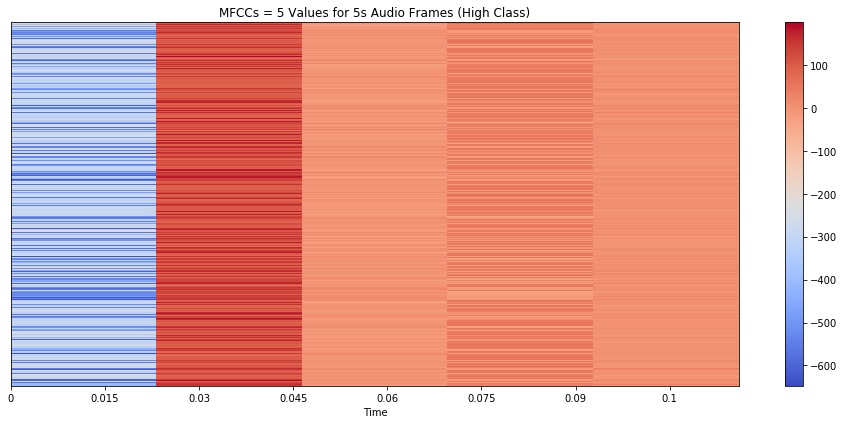

In [114]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(13, 6))
librosa.display.specshow(features, x_axis='time')
plt.colorbar()
plt.title('MFCCs = 5 Values for 5s Audio Frames (High Class)')
plt.tight_layout()
plt.savefig('test saving.png')
#Correct Interpretation of MFCC Spectrograms??: https://dsp.stackexchange.com/questions/38830/whats-the-correct-graphical-interpretation-of-a-series-of-mfcc-vectors

In [4]:
features.shape #1424 Frames (Segments), 5 MFCCs
len(features[1])

21

#### Plot of spectrograms using Librosa module
- Reference: https://librosa.github.io/librosa/generated/librosa.display.specshow.html

Text(0.5,1,'Linear power spectrogram (grayscale)')

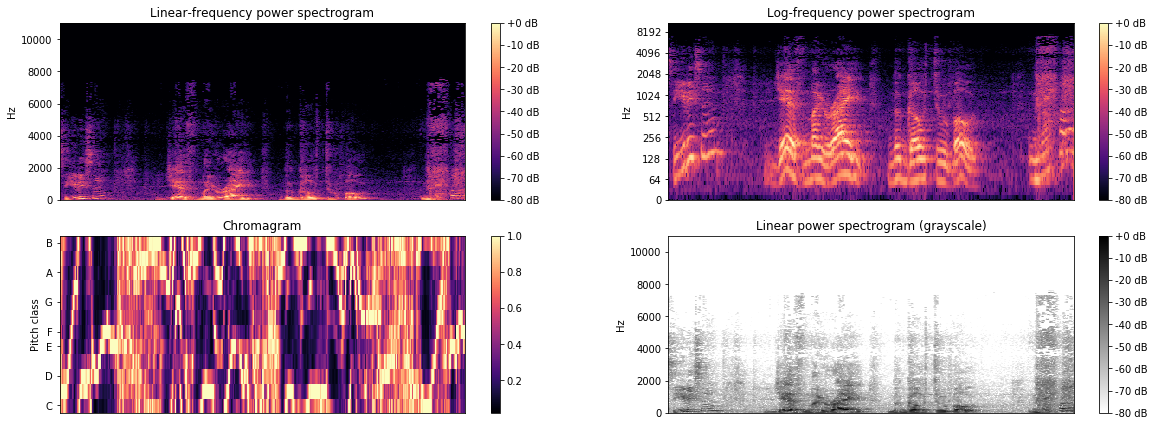

In [136]:
#Visualize an STFT power spectrum
import matplotlib.pyplot as plt
y , sr = librosa.load('audio-data/001 - Low/Avalinguo - Xoca and Josué segment 100 - J.mp3', sr=None) # Using my own audio segment
#y, sr = librosa.load(librosa.util.example_audio_file())
plt.figure(figsize=(20, 15))
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max) #Convert amplitude into db
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear') #Linear Scale
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

# The above one on a logarithmic scale
plt.subplot(4, 2, 2)
#plt.figure(figsize=(20, 10))
librosa.display.specshow(D, y_axis='log') #Log scale
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

# Draw a chromagram with pitch classes
C = librosa.feature.chroma_cqt(y=y, sr=sr)
plt.subplot(4, 2, 3)
librosa.display.specshow(C, y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')

#Force a grayscale colormap (white -> black)
plt.subplot(4, 2, 4)
librosa.display.specshow(D, cmap='gray_r', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear power spectrogram (grayscale)')

### Multilayer Perceptron (MLP) for multi-class softmax classification (Keras Tensorflow)

In [343]:
# coding= UTF-8
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split

# Fix random seed number
np.random.seed(7)

# Load the data
X = np.load('feat.npy')
y = np.load('label.npy').ravel() #Return a contiguous flattened array.

number_of_features = len(X[1]) #This is variable with each run
number_of_classes = 3

# Sample data randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) #70% Train, 30% Test

# Neural Network Architecture
model = Sequential() # Define Sequential model

# Using relu on the first two layers and softmax on the output layer

# 1st Layer
#N neurons, Number_Fatures-dimensional vectors
model.add(Dense(512, input_dim=number_of_features, activation='relu')) #32, 64, 128, 256, 512, 1024
model.add(Dropout(0.5))

# 2nd Layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# 3rd Layer. Output 3 neurons corresponding the number of classes
# The sigmoid function is used for the two-class logistic regression, 
# whereas the softmax function is used for the multiclass logistic regression 
model.add(Dense(number_of_classes, activation='softmax'))

# Model Compilation. Loss for multi-class classification problem
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
rmsprop = 'rmsprop'
adam = 'adam'
model.compile(loss='categorical_crossentropy',
              optimizer= rmsprop, #rmsprop better than sgd
              metrics=['accuracy'])

# Convert labels to categorical one-hot encoding
y_train = keras.utils.to_categorical(y_train-1, num_classes= number_of_classes) # Convert class vector into binary Matrix
y_test = keras.utils.to_categorical(y_test-1, num_classes= number_of_classes)

# Train and test
model.fit(X_train, y_train, epochs=300, batch_size=64) #batch 32, 64, 128, 256, 512
score, acc = model.evaluate(X_test, y_test, batch_size=64)

Epoch 1/300
996/996 [==============================] - 0s 162us/step - loss: 9.3432 - acc: 0.3665
Epoch 2/300
996/996 [==============================] - 0s 415us/step - loss: 9.4957 - acc: 0.3855
Epoch 3/300
996/996 [==============================] - 0s 332us/step - loss: 8.7956 - acc: 0.4277
Epoch 4/300
996/996 [==============================] - 0s 326us/step - loss: 7.7137 - acc: 0.5050
Epoch 5/300
996/996 [==============================] - 0s 379us/step - loss: 7.9220 - acc: 0.4859
Epoch 6/300
996/996 [==============================] - 0s 270us/step - loss: 7.8554 - acc: 0.4940
Epoch 7/300
996/996 [==============================] - 0s 324us/step - loss: 7.4339 - acc: 0.5221
Epoch 8/300
996/996 [==============================] - 0s 431us/step - loss: 7.1396 - acc: 0.5371
Epoch 9/300
996/996 [==============================] - 0s 241us/step - loss: 7.2707 - acc: 0.5301
Epoch 10/300
996/996 [==============================] - 0s 255us/step - loss: 7.0143 - acc: 0.5532
Epoch 11/300
996/99

In [344]:
print 'Test score:', score
print'Test accuracy:', acc

Test score: 0.39868450944668776
Test accuracy: 0.9252336476450769


#### SVM Classification 

- The C parammeter in SVM: https://stats.stackexchange.com/questions/31066/what-is-the-influence-of-c-in-svms-with-linear-kernel
- What are C and gamma in SVM? https://www.quora.com/What-are-C-and-gamma-with-regards-to-a-support-vector-machine

In [34]:
#Load data from generated numpy files
X = np.load('feat.npy') # list of features
y = np.load('label.npy').ravel() # labels are the target

In [35]:
X[:10]

array([[-5.34424579e+02,  1.33068527e+02, -1.79770734e+01,
         3.67421680e+01, -1.32392748e+01, -6.33357454e+00,
         3.59543238e+00, -6.60597891e+00,  1.07060114e+01,
        -9.19224115e+00, -2.01480347e+00, -1.16925599e+00,
        -8.34503988e+00, -2.18270252e+00, -9.45395459e+00,
        -2.95419291e+00, -5.72984596e+00, -2.85809285e+00,
         2.85321205e+00, -3.86206355e+00,  3.08070349e-02],
       [-2.28339962e+02,  1.80899968e+02, -1.84506893e+01,
         1.73562156e+01, -1.45058703e+01,  1.98873085e+01,
        -1.78443659e+01,  9.34266608e+00, -1.47710763e+00,
        -7.51841369e+00,  2.61104404e-01, -1.87336682e+00,
         5.19664356e+00, -8.82448664e+00,  2.69456739e+00,
        -2.75663147e+00, -1.31644376e+00, -4.88328073e+00,
         3.54885642e-01, -2.35362479e-01,  3.41604281e-02],
       [-6.22558218e+02,  1.33293372e+02,  3.31136877e+00,
         4.24647036e+00,  1.08012653e+01,  8.33817712e+00,
         1.29922554e+01, -7.47453400e+00, -1.20448942e

In [2]:
# coding= UTF-8
import numpy as np 
import sklearn
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

#Load data from generated numpy files
X = np.load('feat.npy') # list of features
y = np.load('label.npy').ravel() # labels are the target

# Fix random seed number
np.random.seed(7)

# Load the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30) 
#Dr : 10 fold validation (9 train, 1 test), (8 train , 1 test, 1 train)
#Se entrena clasificador en un ciclo de 10 veces 
#10 fold es parte de Sci-kit

# Data scaling (Do I need it?)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

# SVM classifier
svm_clf = SVC(C=200, gamma = 0.0001, kernel='rbf', decision_function_shape="ovr") 
#svm_clf = LinearSVC(random_state=42) # HandsOn git

# Fit model
svm_clf.fit(X_train, y_train) #From Beif github
#svm_clf.fit(X_train_scaled, y_train) # HandsOn book

# Predictions
y_predict = svm_clf.predict(X_test)


# Accuracy Result
acc = svm_clf.score(X_test, y_test) # From Beif github
print
print("Final accuracy = %0.4f" %acc)
#print('\n')
#print(classification_report(y_test, y_predict))


Final accuracy = 0.9439


In [295]:
# View the predicted probabilities of the first n observations
svm_clf.predict_proba(X_test)[0:10] #IT IS NOT WORKING, CHECK LATER

AttributeError: predict_proba is not available when  probability=False

##### Compute Confussion Matrix

In [5]:
# De-encoding predicted and actual classes (going from numeric to written)
prediction_decoded = label_classes[y_predict]
actual_value_decoded = label_classes[y_test]

In [11]:
## Confusion Matrix
# This is the unnormalized matrix ...
pd.crosstab(actual_value_decoded, prediction_decoded)
#pd.crosstab(test['species'], preds, rownames=['Actual Species'], colnames=['Predicted Species'])

col_0,High,Intermediate,Low
row_0,,,
High,142,0,0
Intermediate,2,144,13
Low,2,7,118


#### Random Forest Classification (Sklearn)

- Tunning parameters of a RF: https://stackoverflow.com/questions/36107820/how-to-tune-parameters-in-random-forest-using-scikit-learn

In [404]:
from sklearn.ensemble import RandomForestClassifier #Random Forest classifier
import pandas as pd 
import numpy as np
np.random.seed(7)

In [461]:
#Load data 
X = np.load('feat.npy') 
y = np.load('label.npy').ravel() 


#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=6)

# Initialize classifier
rf_clf = RandomForestClassifier(n_estimators=350, n_jobs=2, random_state=6, max_features="auto") 

# Train model
rf_clf.fit(X_train, y_train)

# Make predictions
y_prediction = rf_clf.predict(X_test)

# Evaluate accuracy
acc = rf_clf.score(X_test, y_test) 
print "Accuracy = %0.5f" %acc

Accuracy = 0.93458


In [405]:
# View the predicted probabilities of the first n observations
rf_clf.predict_proba(X_test)[0:10]

array([[0.62      , 0.30666667, 0.07333333],
       [0.00666667, 0.92      , 0.07333333],
       [0.        , 0.        , 1.        ],
       [0.45333333, 0.39333333, 0.15333333],
       [0.02      , 0.01333333, 0.96666667],
       [0.11333333, 0.84      , 0.04666667],
       [0.47333333, 0.48      , 0.04666667],
       [0.        , 0.        , 1.        ],
       [0.04      , 0.06      , 0.9       ],
       [0.03333333, 0.04666667, 0.92      ]])

##### Compute Confussion Matrix

In [406]:
# De-encoding predicted and actual classes (going from numeric to written)
prediction_decoded = label_classes[y_prediction]
actual_value_decoded = label_classes[y_test]

## Confusion Matrix
pd.crosstab(actual_value_decoded, prediction_decoded)

#### CNN Classification (Keras Tensorflow)

In [474]:
# coding= UTF-8
import numpy as np
import keras 
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split

# Load data 
X = np.load("feat.npy")
y = np.load('label.npy').ravel()

# Fix random seed number
np.random.seed(7)

number_of_features = len(X[1]) 
number_of_classes = 3

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 233)

# Need to reshape you data to have a spatial dimension for Conv1d to make sense
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# Neural Network Construction
model = Sequential()

# Neural Network Architecture
# Using 1D Convolutions (approriate for audio files)

# first layer has 64 convolution filters 
model.add(Conv1D(64, 3, activation='relu', padding='same', input_shape = (number_of_features, 1))) 
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))

model.add(Dense(number_of_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Convert label to onehot
y_train = keras.utils.to_categorical(y_train - 1, num_classes= number_of_classes) # Converts a class vector (integers) to binary class matrix
y_test = keras.utils.to_categorical(y_test - 1, num_classes= number_of_classes)

# Train Network
model.fit(X_train, y_train, batch_size=32, epochs=90)

# Evaluate model's accuracy with test data
score, acc = model.evaluate(X_test, y_test, batch_size=32) # Computes the loss & accuracy based on the input you pass it

print('Test score:', score) #loss
print('Test accuracy:', acc)

Epoch 1/90
996/996 [==============================] - 0s 473us/step - loss: 1.1946 - acc: 0.4357
Epoch 2/90
996/996 [==============================] - 0s 467us/step - loss: 0.9009 - acc: 0.5783
Epoch 3/90
996/996 [==============================] - 0s 470us/step - loss: 0.7987 - acc: 0.6245
Epoch 4/90
996/996 [==============================] - 0s 483us/step - loss: 0.7336 - acc: 0.6777
Epoch 5/90
996/996 [==============================] - 0s 482us/step - loss: 0.6396 - acc: 0.6998
Epoch 6/90
996/996 [==============================] - 0s 465us/step - loss: 0.5834 - acc: 0.7550
Epoch 7/90
996/996 [==============================] - 0s 496us/step - loss: 0.5407 - acc: 0.7580
Epoch 8/90
996/996 [==============================] - 0s 461us/step - loss: 0.5424 - acc: 0.7550
Epoch 9/90
996/996 [==============================] - 0s 492us/step - loss: 0.4808 - acc: 0.7932
Epoch 10/90
996/996 [==============================] - 0s 498us/step - loss: 0.4580 - acc: 0.7932
Epoch 11/90
996/996 [========

#### RNN Classification (Keras Tensorflow)

- Sigmoid vs Softmax: The sigmoid function is used for the two-class logistic regression (0 or 1, speech or non-speech), whereas the softmax function is used for the multiclass logistic regression (a.k.a. MaxEnt, multinomial logistic regression, softmax Regression, Maximum Entropy Classifier). (dog bark, sea waves, ...)
- Network Architecture: Regarding more general choices, there is rarely a "right" way to construct the architecture. Instead that should be something you test with different meta-params (such as layer sizes, number of layers, amount of drop-out), and should be results-driven (including any limits you might have on resource use for training time/memory use etc).
- https://datascience.stackexchange.com/questions/10048/what-is-the-best-keras-model-for-multi-class-classification

In [477]:
# coding= UTF-8
import os
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense
from keras.optimizers import Adam

# Load data 
X = np.load("feat.npy")
y = np.load('label.npy').ravel()

# Fix random seed number
np.random.seed(7)

number_of_features = len(X[1]) 
number_of_classes = 3

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 230)


# Reshape data for LSTM (Samples, Timesteps, Features)
X_train = np.expand_dims(X_train, axis=2) #(280,193,1)
X_test = np.expand_dims(X_test, axis=2)

y_train = keras.utils.to_categorical(y_train - 1, num_classes= number_of_classes) # Converts a class vector (integers) to binary class matrix
y_test = keras.utils.to_categorical(y_test - 1, num_classes= number_of_classes)

# Build RNN Neural Network
print('Build LSTM RNN model ...')
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=X_train.shape[1:]))
model.add(LSTM(32, return_sequences=False))

#model.add(LSTM(16, return_sequences=False))
model.add(Dense(number_of_classes, activation='softmax'))
          
print("Compiling ...")
model.compile(loss='categorical_crossentropy', # for multiple classes
              optimizer='rmsprop', 
              metrics=['accuracy'])

print(model.summary())

print("Training ...")
model.fit(X_train, y_train, batch_size=64, epochs=60)

print("\nValidating ...")
score, accuracy = model.evaluate(X_test, y_test, batch_size=32, verbose=1)
print("Loss:  ", score)
print("Accuracy:  ", accuracy)

Build LSTM RNN model ...
Compiling ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 23, 256)           264192    
_________________________________________________________________
lstm_46 (LSTM)               (None, 32)                36992     
_________________________________________________________________
dense_143 (Dense)            (None, 3)                 99        
Total params: 301,283
Trainable params: 301,283
Non-trainable params: 0
_________________________________________________________________
None
Training ...
Epoch 1/60
996/996 [==============================] - 5s 5ms/step - loss: 1.0166 - acc: 0.4980
Epoch 2/60
996/996 [==============================] - 6s 6ms/step - loss: 0.8330 - acc: 0.6295
Epoch 3/60
996/996 [==============================] - 5s 5ms/step - loss: 0.6839 - acc: 0.6878
Epoch 4/60
996/996 [==============================] - 6s 6